In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns

In [2]:
order = pd.read_csv('./capstone_jd_msom_data-minus-click-data/JD_order_data.csv')
delivery = pd.read_csv('./capstone_jd_msom_data-minus-click-data/JD_delivery_data.csv')

"The delivery table establishes the linkage between each order (order_ID) and (possibly) multiple shipping packages (i.e., multiple package_IDs) in the event that an order is split into multiple delivery packages for logistical reasons (e.g., an order that involves in-stock and on- order items). **The delivery table contains records for orders delivered with JD Logistics, which represents the majority of 1P orders and some 3P orders**. The orders that cannot find a match record in the delivery table, can be considered delivered by an alternative shipping method."

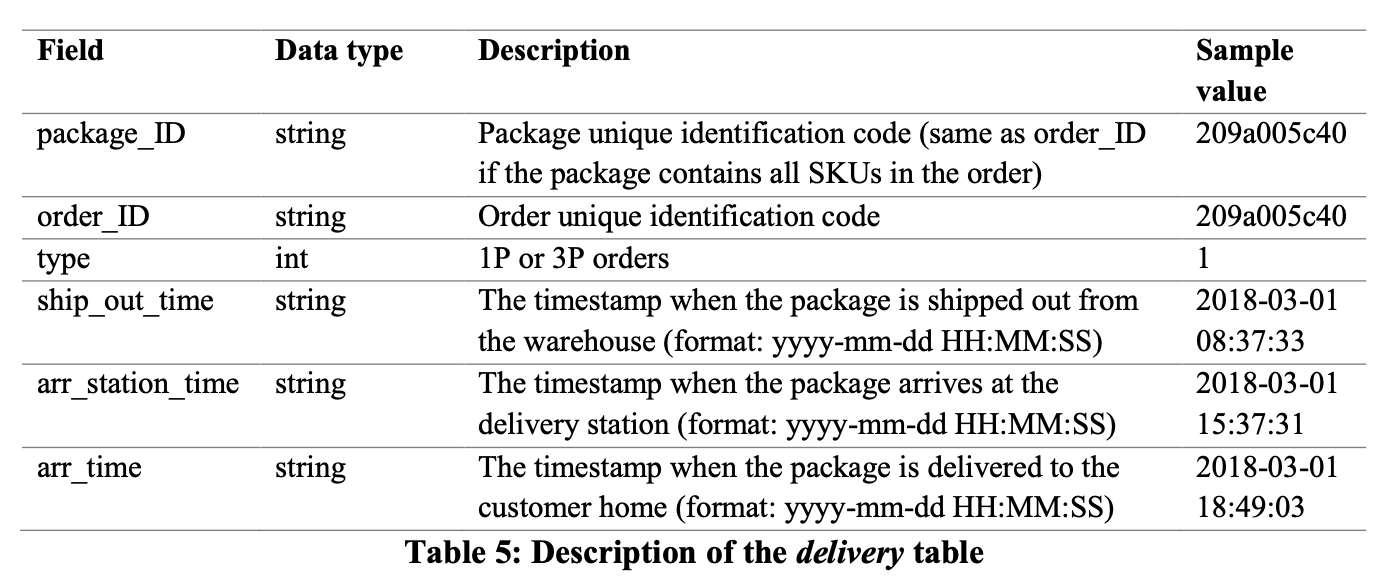

In [3]:
order.head()

order_ID     user_ID      sku_ID  order_date             order_time  \
0  d0cf5cc6db  0abe9ef2ce  581d5b54c1  2018-03-01  2018-03-01 17:14:25.0   
1  7444318d01  33a9e56257  067b673f2b  2018-03-01  2018-03-01 11:10:40.0   
2  f973b01694  4ea3cf408f  623d0a582a  2018-03-01  2018-03-01 09:13:26.0   
3  8c1cec8d4b  b87cb736cb  fc5289b139  2018-03-01  2018-03-01 21:29:50.0   
4  d43a33c38a  4829223b6f  623d0a582a  2018-03-01  2018-03-01 19:13:37.0   

   quantity  type promise  original_unit_price  final_unit_price  \
0         1     2       -                 89.0              79.0   
1         1     1       2                 99.9              53.9   
2         1     1       2                 78.0              58.5   
3         1     1       2                 61.0              35.0   
4         1     1       1                 78.0              53.0   

   direct_discount_per_unit  quantity_discount_per_unit  \
0                       0.0                        10.0   
1                       5.0                        41.0   
2                      19.5                         0.0   
3                       0.0                        26.0   
4                      19.0                         0.0   

   bundle_discount_per_unit  coupon_discount_per_unit  gift_item  dc_ori  \
0                       0.0                       0.0          0       4   
1                       0.0                       0.0          0      28   
2                       0.0                       0.0          0      28   
3                       0.0                       0.0          0       4   
4                       0.0                       6.0          0       3   

   dc_des  
0      28  
1      28  
2      28  
3      28  
4      16

In [4]:
order['type'].value_counts()

1    275468
2    274521
Name: type, dtype: int64

In [5]:
delivery.head()

package_ID    order_ID  type        ship_out_time     arr_station_time  \
0  dc3d6d2258  dc3d6d2258     1  2018-03-01 08:00:00  2018-03-01 15:00:00   
1  19802a570c  19802a570c     1  2018-03-01 10:00:00  2018-03-01 15:00:00   
2  e22627af66  e22627af66     1  2018-03-01 11:00:00  2018-03-01 15:00:00   
3  50d11a586d  50d11a586d     1  2018-03-01 10:00:00  2018-03-01 16:00:00   
4  a3bfe38bf4  a3bfe38bf4     1  2018-03-01 11:00:00  2018-03-01 16:00:00   

              arr_time  
0  2018-03-01 18:00:00  
1  2018-03-01 17:00:00  
2  2018-03-01 17:00:00  
3  2018-03-01 19:00:00  
4  2018-03-01 17:00:00

In [6]:
delivery['order_ID'].nunique()

293204

In [7]:
len(delivery['order_ID'])

293229

In [8]:
delivery.duplicated().any()

False

In [9]:
orderID_counts = delivery['order_ID'].value_counts()
duplicate_orderID = set(orderID_counts[orderID_counts>1].keys()) # contain all duplicated orderIDs
#delivery[delivery['order_ID'].isin(duplicate_orderID)]

Some orders have multiple packages that have different delivery timeline. We can aggregate them into an average

In [10]:
# convert column types
for column in ['ship_out_time', 'arr_station_time','arr_time']:
    delivery[column] = pd.to_datetime(delivery[column])

In [11]:
delivery['delta'] = delivery['arr_station_time'] - delivery['ship_out_time']

In [12]:
# aggregate delivery delta by order_ID
order_delta = delivery[['order_ID','delta']].groupby('order_ID').mean(numeric_only = False)
order_delta.head()

delta
order_ID                  
0000095025 0 days 16:00:00
00000e13eb 0 days 22:00:00
0000132b39 0 days 12:00:00
000064fa67 0 days 05:00:00
0000bde331 0 days 15:00:00

In [13]:
# merge order_delta table with order table

In [14]:
dc_delta = pd.merge(order[['order_ID','dc_ori','dc_des']], order_delta, how = 'inner', right_index = True, left_on = 'order_ID')
dc_delta

order_ID  dc_ori  dc_des           delta
1       7444318d01      28      28 0 days 19:00:00
2       f973b01694      28      28 0 days 19:00:00
3       8c1cec8d4b       4      28 0 days 23:00:00
4       d43a33c38a       3      16 0 days 11:00:00
5       e0f5386d87       3      16 0 days 11:00:00
...            ...     ...     ...             ...
549977  5fd298d448       2       2 1 days 18:00:00
549983  9fa0694b3b       2       2 0 days 10:00:00
549985  c9d77a7ed0      59       2 1 days 20:00:00
549986  b9ad79338f       2       2 0 days 17:00:00
549988  02d31f05c9       4      28 3 days 18:00:00

[326834 rows x 4 columns]

In [15]:
dc_delta.nunique()

order_ID    293204
dc_ori          56
dc_des          60
delta          309
dtype: int64

In [16]:
dc_delta['delta'].dt.seconds // 3600 # hours

1         19
2         19
3         23
4         11
5         11
          ..
549977    18
549983    10
549985    20
549986    17
549988    18
Name: delta, Length: 326834, dtype: int64

In [17]:
dc_delta['hours'] = dc_delta['delta'].dt.total_seconds() // 3600

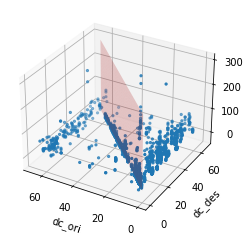

In [18]:
sample = dc_delta.sample(frac = 0.01)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample['dc_ori'],sample['dc_des'],sample['hours'], marker = '.')
ax.invert_xaxis()

X, Z = np.meshgrid(range(63), range(300))
Y = (X)
ax.plot_surface(X, Y, Z, alpha=0.2, color = 'red')
plt.xlabel('dc_ori')
plt.ylabel('dc_des')
plt.show()

In [19]:
dc_delta

order_ID  dc_ori  dc_des           delta  hours
1       7444318d01      28      28 0 days 19:00:00   19.0
2       f973b01694      28      28 0 days 19:00:00   19.0
3       8c1cec8d4b       4      28 0 days 23:00:00   23.0
4       d43a33c38a       3      16 0 days 11:00:00   11.0
5       e0f5386d87       3      16 0 days 11:00:00   11.0
...            ...     ...     ...             ...    ...
549977  5fd298d448       2       2 1 days 18:00:00   42.0
549983  9fa0694b3b       2       2 0 days 10:00:00   10.0
549985  c9d77a7ed0      59       2 1 days 20:00:00   44.0
549986  b9ad79338f       2       2 0 days 17:00:00   17.0
549988  02d31f05c9       4      28 3 days 18:00:00   90.0

[326834 rows x 5 columns]

In [20]:
dc_delta['hours'].value_counts().sort_index()

-82.0     1
-34.0     1
-26.0     1
-11.0     1
-10.0     2
         ..
 462.0    1
 471.0    1
 473.0    1
 486.0    1
 641.0    1
Name: hours, Length: 304, dtype: int64

In [21]:
# delete negative hour
dc_delta = dc_delta[dc_delta['hours'] >= 0]

Explore 'hours' variable

<AxesSubplot:>

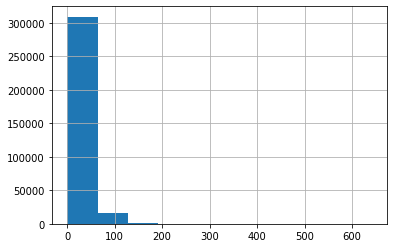

In [22]:
dc_delta['hours'].hist() # looks like data is right skewed -> take log transformation

In [23]:
np.log(dc_delta['hours']).to_frame()

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


hours
1       2.944439
2       2.944439
3       3.135494
4       2.397895
5       2.397895
...          ...
549977  3.737670
549983  2.302585
549985  3.784190
549986  2.833213
549988  4.499810

[326819 rows x 1 columns]

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hours'>

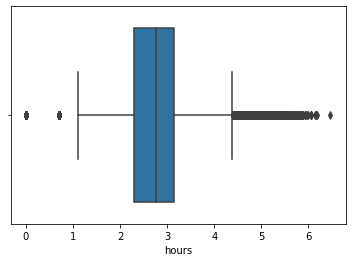

In [24]:
sns.boxplot(np.log(dc_delta['hours']))

In [25]:
dc_delta.groupby(['dc_ori','dc_des']).agg({'hours': [np.min, np.max, np.median, np.mean]})

hours                         
               amin   amax median       mean
dc_ori dc_des                               
1      1        2.0   30.0   15.0  13.674569
       18      46.0   46.0   46.0  46.000000
       31      37.0   48.0   40.5  41.625000
       39      22.0   87.0   29.0  36.666667
       46      47.0   47.0   47.0  47.000000
...             ...    ...    ...        ...
65     60      73.0   89.0   86.0  83.500000
       61      74.0  111.0   92.5  92.500000
       64      19.0   46.0   38.0  33.200000
66     20       4.0   21.0   17.0  14.876923
67     67       1.0   23.0   13.0  12.137045

[627 rows x 4 columns]

In [26]:
# since we only care about the dc pair not the order, we reverse the reversed pair before group by
# for example, we want to treat order shipped from 31->1 the same as 1->31, so we reverse 31->1 before group by

# reverse pairs where dc_ori > dc_des
reversed_dc = dc_delta[dc_delta['dc_ori']>dc_delta['dc_des']].copy()
tmp = reversed_dc['dc_ori'].copy()
reversed_dc['dc_ori'] = reversed_dc['dc_des']
reversed_dc['dc_des'] = tmp
reversed_dc

# concat the reversed pairs with "normal" pairs where dc_ori <= dc_des
concated = pd.concat([dc_delta[dc_delta['dc_ori']<=dc_delta['dc_des']], reversed_dc])

In [27]:
paired = concated.groupby(['dc_ori','dc_des']).agg({'hours': [np.min, np.max, np.median, np.mean]})
paired

hours                         
               amin   amax median       mean
dc_ori dc_des                               
1      1        2.0   30.0   15.0  13.674569
       7       14.0  133.0   31.0  35.833750
       8       42.0   65.0   48.0  52.600000
       18      46.0   46.0   46.0  46.000000
       31      37.0   48.0   43.0  42.789474
...             ...    ...    ...        ...
61     61       2.0   26.0   14.0  13.468189
       65      74.0  111.0   92.5  92.500000
64     64       1.0   32.0   14.0  12.771889
       65      19.0   46.0   38.0  33.200000
67     67       1.0   23.0   13.0  12.137045

[547 rows x 4 columns]

Since median and mean do not differ much, we will use mean number of hours between two distribution centers as a proxy for their distance

In [28]:
paired[paired.index.get_level_values('dc_ori') == 1]

hours                         
               amin   amax median       mean
dc_ori dc_des                               
1      1        2.0   30.0   15.0  13.674569
       7       14.0  133.0   31.0  35.833750
       8       42.0   65.0   48.0  52.600000
       18      46.0   46.0   46.0  46.000000
       31      37.0   48.0   43.0  42.789474
       39      14.0   87.0   26.0  32.315789
       46      42.0   47.0   42.0  43.250000
       53      41.0   63.0   43.0  47.500000
       56      25.0   45.0   28.0  32.333333
       58      38.0   95.0   49.0  57.166667
       59      38.0   96.0   47.0  49.593220
       65      68.0   92.0   89.0  83.000000

In [36]:
order.groupby('order_ID')[['quantity']].sum().mean()

quantity    1.374238
dtype: float64

In [37]:
order

order_ID     user_ID      sku_ID  order_date             order_time  \
0       d0cf5cc6db  0abe9ef2ce  581d5b54c1  2018-03-01  2018-03-01 17:14:25.0   
1       7444318d01  33a9e56257  067b673f2b  2018-03-01  2018-03-01 11:10:40.0   
2       f973b01694  4ea3cf408f  623d0a582a  2018-03-01  2018-03-01 09:13:26.0   
3       8c1cec8d4b  b87cb736cb  fc5289b139  2018-03-01  2018-03-01 21:29:50.0   
4       d43a33c38a  4829223b6f  623d0a582a  2018-03-01  2018-03-01 19:13:37.0   
...            ...         ...         ...         ...                    ...   
549984  3ad06b9fbe  a27b3ed4d4  a9109972d1  2018-03-31  2018-03-31 01:22:47.0   
549985  c9d77a7ed0  18f92434cd  7f53769d3f  2018-03-31  2018-03-31 08:55:57.0   
549986  b9ad79338f  b5caf8a580  8dc4a01dec  2018-03-31  2018-03-31 13:31:01.0   
549987  be3a9414b1  20ba6655f3  2dd6b818ec  2018-03-31  2018-03-31 12:51:18.0   
549988  02d31f05c9  f260895cbe  10d369ef96  2018-03-31  2018-03-31 18:21:16.0   

        quantity  type promise  original_unit_price  final_unit_price  \
0              1     2       -                 89.0              79.0   
1              1     1       2                 99.9              53.9   
2              1     1       2                 78.0              58.5   
3              1     1       2                 61.0              35.0   
4              1     1       1                 78.0              53.0   
...          ...   ...     ...                  ...               ...   
549984         1     2       -                  0.0              -1.0   
549985         1     1       3                118.0              55.0   
549986         1     1       2                 78.0              78.0   
549987         1     2       -                189.0              78.0   
549988         1     2       4                 68.0              49.0   

        direct_discount_per_unit  quantity_discount_per_unit  \
0                            0.0                        10.0   
1                            5.0                        41.0   
2                           19.5                         0.0   
3                            0.0                        26.0   
4                           19.0                         0.0   
...                          ...                         ...   
549984                       0.0                         0.0   
549985                      63.0                         0.0   
549986                       0.0                         0.0   
549987                     111.0                         0.0   
549988                      19.0                         0.0   

        bundle_discount_per_unit  coupon_discount_per_unit  gift_item  dc_ori  \
0                            0.0                       0.0          0       4   
1                            0.0                       0.0          0      28   
2                            0.0                       0.0          0      28   
3                            0.0                       0.0          0       4   
4                            0.0                       6.0          0       3   
...                          ...                       ...        ...     ...   
549984                       0.0                       1.0          1       2   
549985                       0.0                       0.0          0      59   
549986                       0.0                       0.0          0       2   
549987                       0.0                       0.0          0       4   
549988                       0.0                       0.0          0       4   

        dc_des  
0           28  
1           28  
2           28  
3           28  
4           16  
...        ...  
549984       2  
549985       2  
549986       2  
549987      28  
549988      28  

[549989 rows x 17 columns]